## I couldn't find a suitable dataset for this project so I opted to use Q&A duplication dataset from Kaggle.
# I hope it's enough

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import scipy.sparse as sp
from scipy.sparse import vstack, hstack
import torch

from sentence_transformers import SparseEncoder, SentenceTransformer, CrossEncoder
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from openai import OpenAI




The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


Loaded 5000 rows


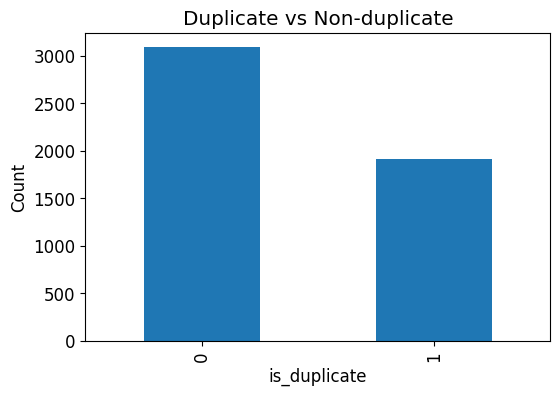

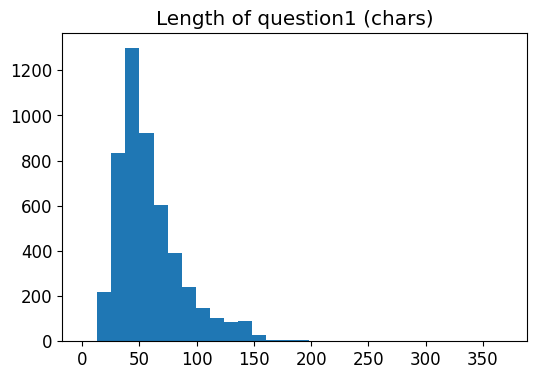

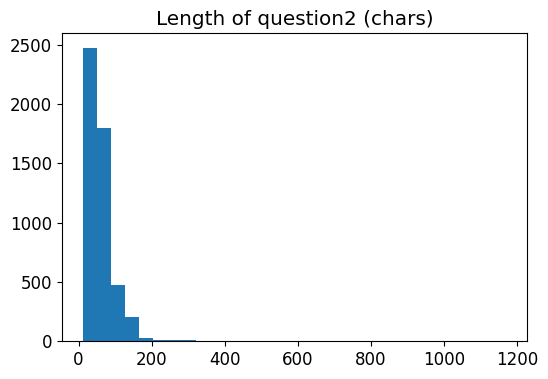

In [ ]:

N = 5000
DATA_PATH = "train.csv.zip" # Kaggle Quora dataset
# https://www.kaggle.com/c/quora-question-pairs/data?select=train.csv.zip

df = pd.read_csv(DATA_PATH, compression="zip").iloc[:N]
print(f"Loaded {len(df)} rows")


df.is_duplicate.value_counts().plot.bar(title="Duplicate vs Non-duplicate")
plt.ylabel("Count"); plt.show()

for col in ["question1","question2"]:
    lens = df[col].astype(str).str.len()
    plt.hist(lens, bins=30)
    plt.title(f"Length of {col} (chars)")
    plt.show()


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"



In [ ]:

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()  

sparse_model = SparseEncoder(
    "naver/splade-cocondenser-ensembledistil",
    device=device,
    trust_remote_code=True
)

def get_sparse_csr(sentences, model, batch_size=128, topk=None):
    """
    Encodes `sentences` in batches into a SciPy CSR matrix.
    Optionally keeps only the top-k nonzeros per batch-chunk.
    """
    chunks = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i : i + batch_size]
        emb = model.encode(batch, batch_size=batch_size, convert_to_numpy=False)
        coo = emb.coalesce()
        rows, cols = coo.indices()[0].cpu().numpy(), coo.indices()[1].cpu().numpy()
        vals       = coo.values().cpu().numpy()

        if topk:


            idx = np.argsort(vals)[-topk:]
            rows, cols, vals = rows[idx], cols[idx], vals[idx]

        chunk = sp.coo_matrix((vals, (rows, cols)), shape=coo.shape).tocsr()
        chunks.append(chunk)

        # cleanup
        del emb, coo, rows, cols, vals
        torch.cuda.empty_cache()

    return vstack(chunks)

# build the flat list and get your full sparse matrix
flat   = [q for pair in zip(df.question1, df.question2) for q in pair]
full_sp = get_sparse_csr(flat, sparse_model, batch_size=128, topk=100)
s1, s2 = full_sp[:N], full_sp[N:]

# Sparsity diagnostics
density = full_sp.nnz / (full_sp.shape[0] * full_sp.shape[1])
print(f"SPLADE density: {density:.6f}")



  0%|          | 0/79 [00:00<?, ?it/s]

SPLADE density: 0.000026


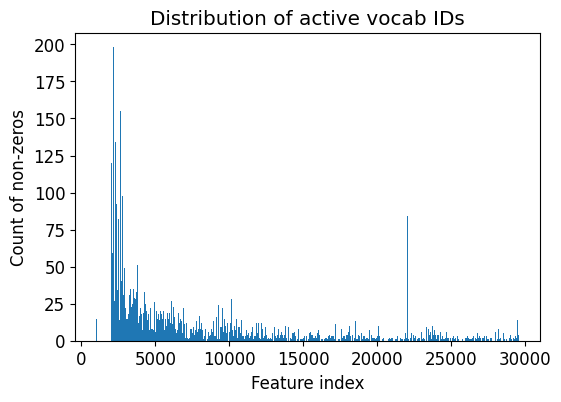

In [14]:
plt.figure(figsize=(6,4))
plt.hist(cols, bins=1000)
plt.xlabel("Feature index")
plt.ylabel("Count of non-zeros")
plt.title("Distribution of active vocab IDs")
plt.show()


/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


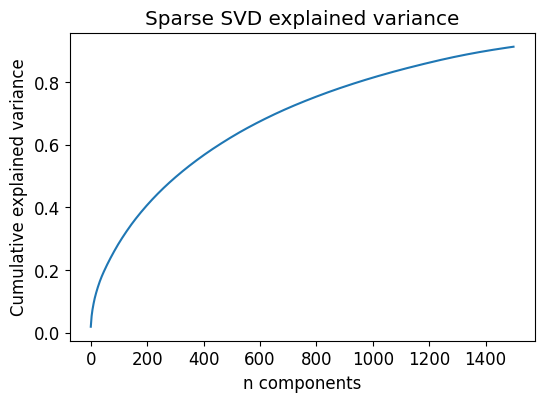

In [ ]:

svd = TruncatedSVD(n_components=1500, random_state=42)
X_sp_red = svd.fit_transform(hstack([abs(s1-s2), s1.multiply(s2)]))

explained = svd.explained_variance_ratio_
plt.plot(np.cumsum(explained))
plt.xlabel("n components")
plt.ylabel("Cumulative explained variance")
plt.title("Sparse SVD explained variance"); plt.show()


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


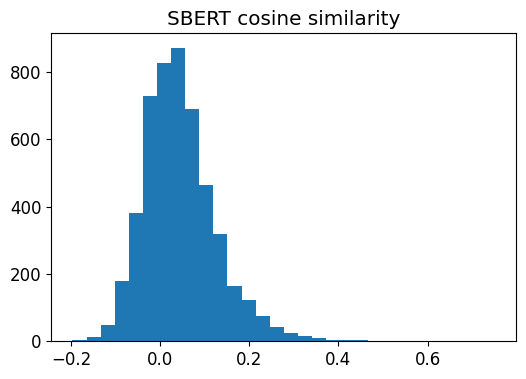

/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

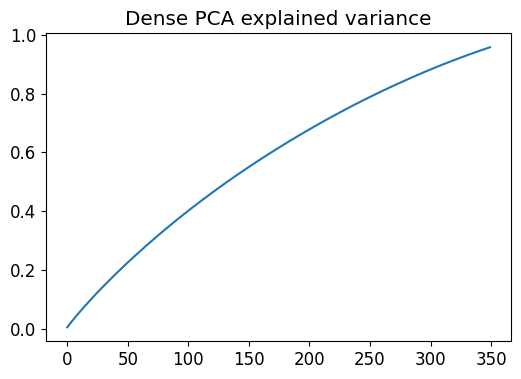

In [ ]:

dense_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
emb_dense = dense_model.encode(flat, batch_size=64, convert_to_numpy=True, show_progress_bar=True)
d1, d2 = emb_dense[:N], emb_dense[N:]

# Cosine‐sim distribution
cosims = np.diag(cosine_similarity(d1, d2))
plt.hist(cosims, bins=30)
plt.title("SBERT cosine similarity"); plt.show()

# PCA on dense diffs
pca = PCA(n_components=350, random_state=42)
X_dn_red = pca.fit_transform(np.hstack([np.abs(d1-d2), d1*d2]))
explained = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained))
plt.title("Dense PCA explained variance"); plt.show()


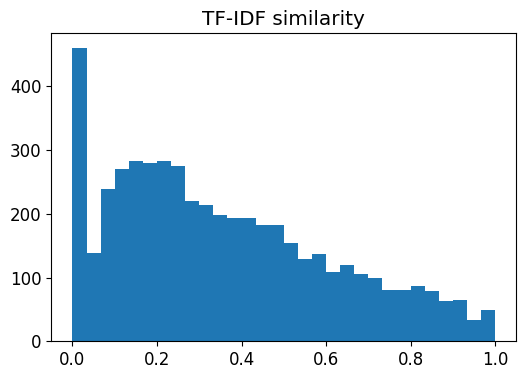

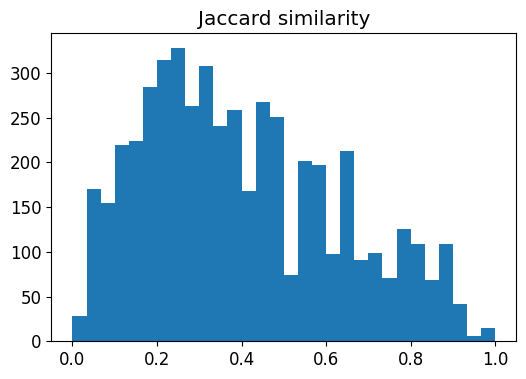

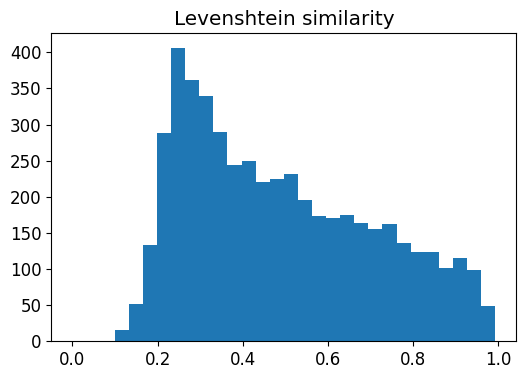

In [ ]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.metrics import edit_distance

tok = TreebankWordTokenizer().tokenize

jacc, lev = [], []
for q1, q2 in zip(df.question1, df.question2):
    t1 = set(tok(str(q1).lower()))
    t2 = set(tok(str(q2).lower()))
    jacc.append(len(t1 & t2) / (len(t1 | t2) + 1e-8))
    lev.append(1 - edit_distance(str(q1), str(q2)) / max(len(q1), len(q2), 1))


for arr, name in [(tfidf_sim, "TF-IDF"), (jacc, "Jaccard"), (lev, "Levenshtein")]:
    plt.hist(arr, bins=30)
    plt.title(f"{name} similarity")
    plt.show()


config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

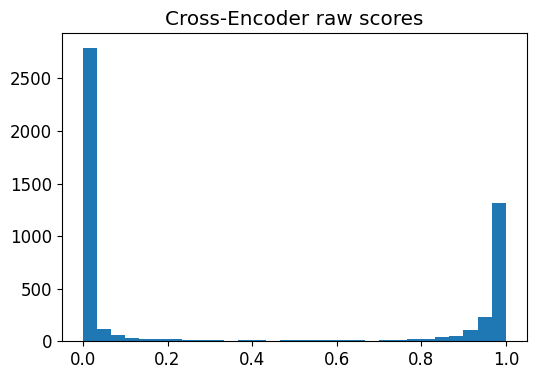

In [ ]:

xe_model = CrossEncoder("cross-encoder/quora-distilroberta-base", device=device, num_labels=1)
scores = xe_model.predict(list(zip(df.question1, df.question2)), batch_size=32)
xe_feat = (scores - scores.min())/(scores.max()-scores.min())

plt.hist(scores, bins=30)
plt.title("Cross-Encoder raw scores"); plt.show()


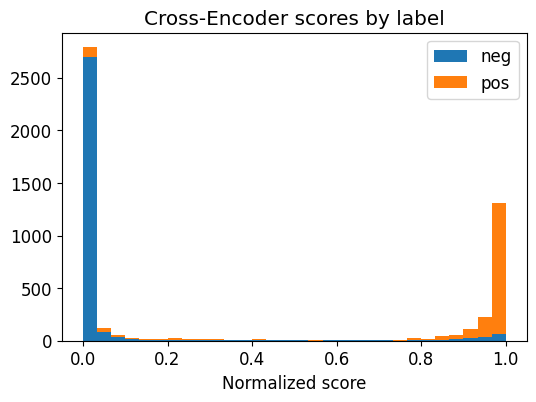

In [19]:
neg = xe_feat[df.is_duplicate == 0]
pos = xe_feat[df.is_duplicate == 1]

plt.hist([neg, pos], bins=30, stacked=True, label=["neg","pos"])
plt.title("Cross-Encoder scores by label")
plt.xlabel("Normalized score")
plt.legend()
plt.show()


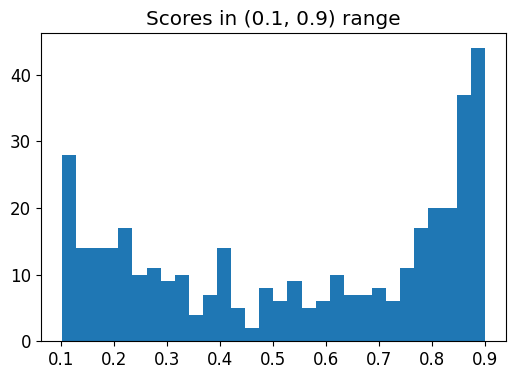

In [20]:
zoom = (xe_feat > 0.1) & (xe_feat < 0.9)
plt.hist(xe_feat[zoom], bins=30)
plt.title("Scores in (0.1, 0.9) range")
plt.show()


In [ ]:
nli    = pipeline(
    "text-classification",
    model="roberta-large-mnli",
    return_all_scores=True
)
SYSTEM = "You are an assistant that rates how much two questions are duplicates on a 0–1 scale (0=no, 1=yes)."


def ce_score(q1: str, q2: str) -> float:
    raw = xe_model.predict([[q1, q2]])[0]             
    return float(1 / (1 + np.exp(-raw)))              


def nli_score(q1: str, q2: str) -> float:
    out = nli(inputs=q1, text_pair=q2)[0]
    return float(next(x["score"] for x in out if x["label"] == "ENTAILMENT"))


def llm_score(q1: str, q2: str, model: str = "gpt-4o-mini") -> float:
    resp = client.chat.completions.create(
        model=model,
        temperature=0,
        messages=[
            {"role":"system", "content": SYSTEM},
            {"role":"user",   "content": f"Q1: {q1}\nQ2: {q2}\n\nOn a scale of 0–1, how duplicate are these? Just reply with a single decimal number."}
        ],
    )
    text = resp.choices[0].message.content.strip()
    m = re.search(r"\d+\.\d+|\d+", text)
    if not m:
        raise ValueError(f"No numeric rating found in LLM response: {text!r}")
    return float(m.group())


def logprob_score(q1: str, q2: str, model: str = "gpt-4o-mini") -> float:
    resp = client.chat.completions.create(
        model=model,
        temperature=0,
        echo=True,
        logprobs=0,
        messages=[
            {"role":"system","content": q1},
            {"role":"user",  "content": q2},
        ],
    )
    lp = np.mean(resp.choices[0].logprobs.token_logprobs)
    return float(1 / (1 + np.exp(-lp)))


df100 = df.iloc[:100].copy()

df100["ce_score"]      = df100.apply(lambda r: ce_score(r.question1,   r.question2), axis=1)
df100["nli_score"]     = df100.apply(lambda r: nli_score(r.question1,  r.question2), axis=1)
df100["llm_score"]     = df100.apply(lambda r: llm_score(r.question1,  r.question2), axis=1)



/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


TypeError: Completions.create() got an unexpected keyword argument 'echo'

In [ ]:
def logprob_score(q1: str, q2: str, model: str = "gpt-4o-mini") -> float:
    resp = client.chat.completions.create(
        model=model,
        temperature=0,
        logprobs=True,
        messages=[
            {"role":"system","content": q1},
            {"role":"user",  "content": q2},
        ],
    )

    token_infos = resp.choices[0].logprobs.content  

    lps = [tok.logprob for tok in token_infos if tok.logprob is not None]
    avg_lp = np.mean(lps)
    return float(1 / (1 + np.exp(-avg_lp)))


df100["logprob_score"] = df100.apply(lambda r: logprob_score(r.question1, r.question2), axis=1)


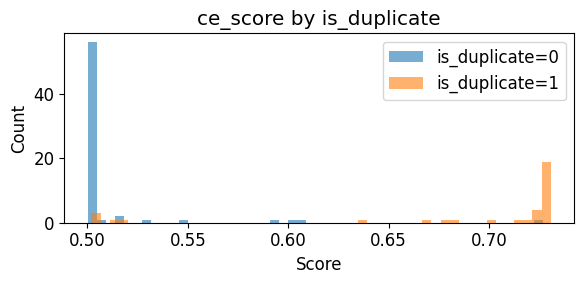

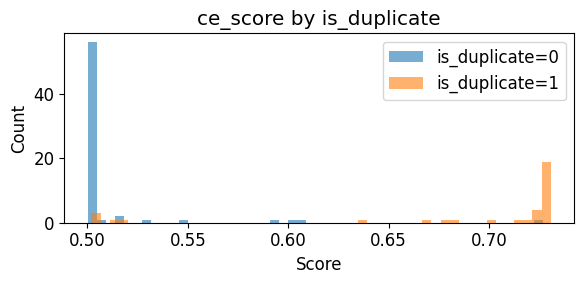

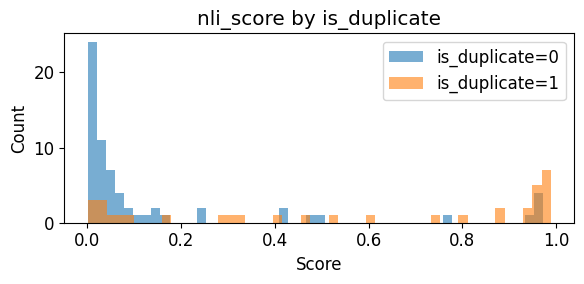

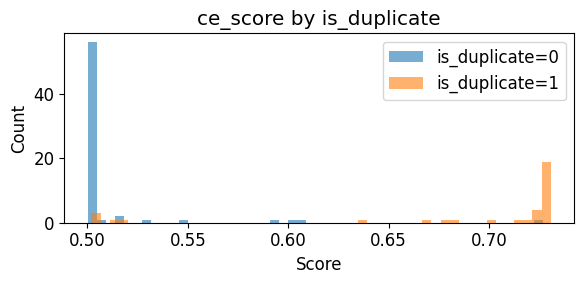

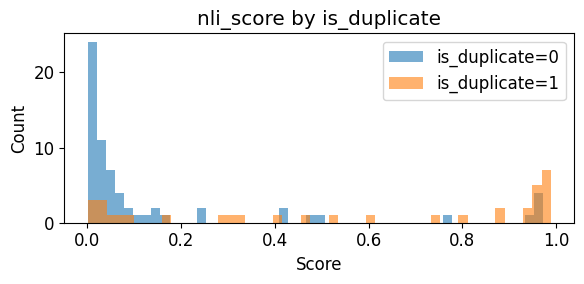

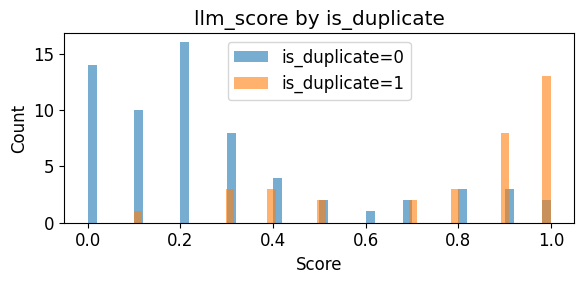

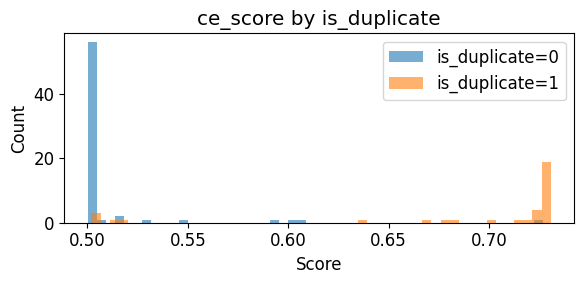

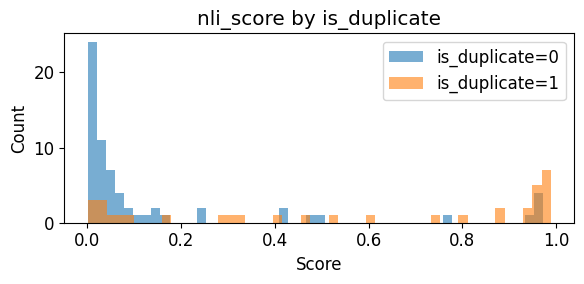

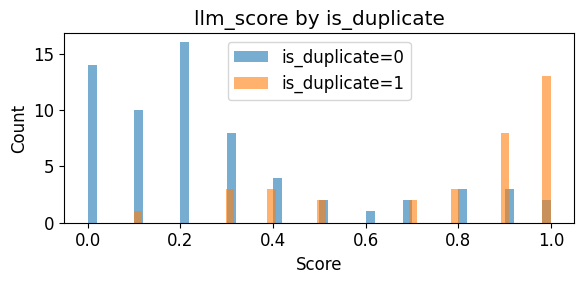

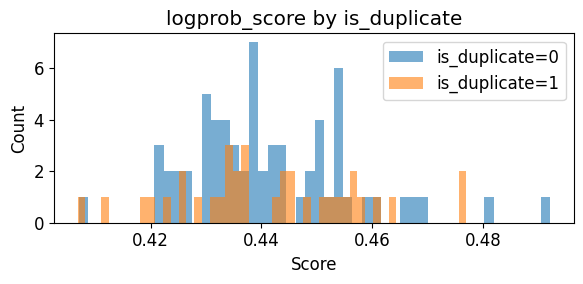

In [ ]:


features = ["ce_score", "nli_score", "llm_score", "logprob_score"]
for feat in features:
    plt.figure(figsize=(6,3))
    for lbl, color in zip([0,1], ["tab:blue","tab:orange"]):
        data = df100.loc[df100["is_duplicate"] == lbl, feat]
        plt.hist(data, bins=50, alpha=0.6, color=color, label=f"is_duplicate={lbl}")
    plt.title(f"{feat} by is_duplicate")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:

for feat in features:
    preds = (df100[feat] >= 0.5).astype(int)
    acc   = (preds == df100["is_duplicate"]).mean()
    print(f"{feat:14s} accuracy @0.5 = {acc:.3f}")

ce_score       accuracy @0.5 = 0.350
nli_score      accuracy @0.5 = 0.780
llm_score      accuracy @0.5 = 0.800
logprob_score  accuracy @0.5 = 0.650


In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    classification_report,
    brier_score_loss
)

y_true = df100["is_duplicate"].values

for feat in features:
    y_score = df100[feat].values


    roc_auc = roc_auc_score(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc  = auc(recall, precision)
    brier   = brier_score_loss(y_true, y_score)  #

    print(f"\n=== {feat} ===")
    print(f"ROC AUC:   {roc_auc:.3f}")
    print(f"PR  AUC:   {pr_auc:.3f}")
    print(f"Brier:     {brier:.3f}")


    best_thr, best_f1 = 0.0, 0.0
    for thr in np.linspace(0, 1, 101):
        f1 = f1_score(y_true, (y_score >= thr).astype(int))
        if f1 > best_f1:
            best_f1, best_thr = f1, thr

    print(f"Best F1:   {best_f1:.3f} at threshold={best_thr:.2f}")


    preds = (y_score >= best_thr).astype(int)
    print(classification_report(y_true, preds, digits=3))



=== ce_score ===
ROC AUC:   0.976
PR  AUC:   0.956
Brier:     0.206
Best F1:   0.909 at threshold=0.61
              precision    recall  f1-score   support

           0      0.928     0.985     0.955        65
           1      0.968     0.857     0.909        35

    accuracy                          0.940       100
   macro avg      0.948     0.921     0.932       100
weighted avg      0.942     0.940     0.939       100


=== nli_score ===
ROC AUC:   0.802
PR  AUC:   0.724
Brier:     0.180
Best F1:   0.714 at threshold=0.25
              precision    recall  f1-score   support

           0      0.846     0.846     0.846        65
           1      0.714     0.714     0.714        35

    accuracy                          0.800       100
   macro avg      0.780     0.780     0.780       100
weighted avg      0.800     0.800     0.800       100


=== llm_score ===
ROC AUC:   0.887
PR  AUC:   0.808
Brier:     0.145
Best F1:   0.747 at threshold=0.31
              precision    recal

/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

In [2]:
# Reload the model and visualize decision boundary
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Load the data and take 1000 samples for visualization
X_test = pd.read_csv("train.csv.zip", compression="zip").iloc[:1000].values


# Load the saved stacking model
model_path = "results/stacking_model.joblib"
stack_model = joblib.load(model_path)

# Reduce feature space for visualization
pca_visual = PCA(n_components=2, random_state=42)
X_reduced = pca_visual.fit_transform(X_test)

# Predict probabilities
probs = stack_model.predict_proba(X_test)[:, 1]

# Scatter plot of decision boundary
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=probs, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Predicted Probability")
plt.title("Decision Boundary Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results/stacking_model.joblib'